In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from timm import create_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import layers, models, mixed_precision


In [25]:
DATA_DIR = '../data/raw/'
BATCH_SIZE = 8
IMG_SIZE = (224,224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),  # Ensure resizing images to 224x224
    shuffle=True
)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size).take(val_size)


Found 2804 files belonging to 2 classes.


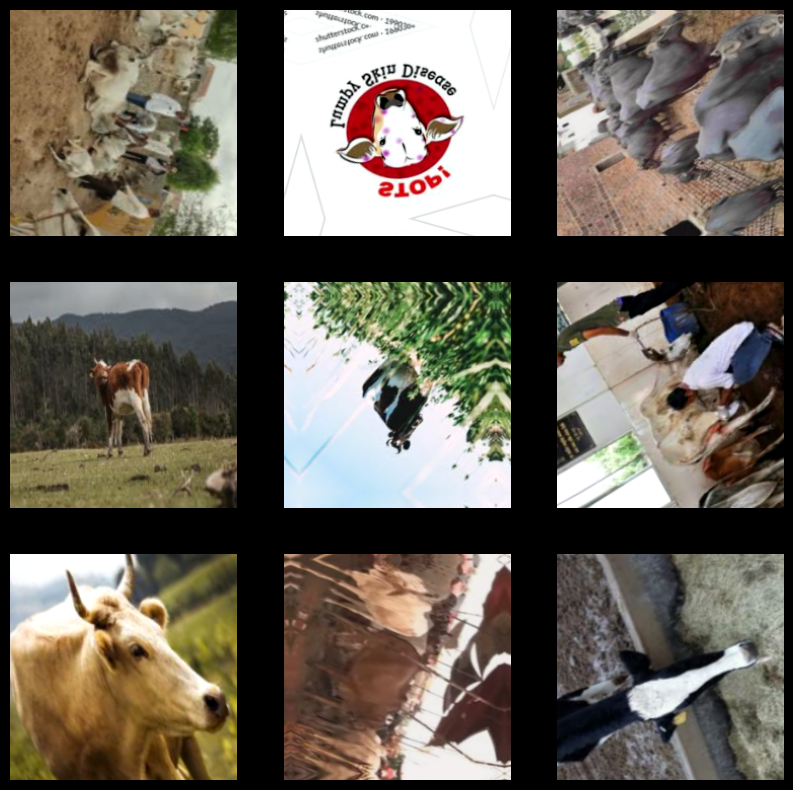

In [3]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# Visualize augmented data
for images, _ in train_data.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis('off')
    plt.show()


In [20]:
def clean_images(img_dir, target_size=(IMG_SIZE[0], IMG_SIZE[1])):
    classes = os.listdir(img_dir)
    for class_name in classes:
        class_path = os.path.join(img_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, target_size)
                    if img is not None and img.shape[2] == 3:
                        cv2.imwrite(img_path, img)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

clean_images(DATA_DIR)


In [28]:
import cv2
def add_gaussian_noise(img):
    noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    return noisy_img

def add_salt_and_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02):
    noisy_img = img.copy()
    total_pixels = img.size // 3
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    # Add salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy_img[coords[0], coords[1], :] = 255

    # Add pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy_img[coords[0], coords[1], :] = 0

    return noisy_img

def apply_noise_to_dataset(img_dir, noise_type='gaussian'):
    classes = os.listdir(img_dir)
    for class_name in classes:
        class_path = os.path.join(img_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    if noise_type == 'gaussian':
                        noisy_img = add_gaussian_noise(img)
                    elif noise_type == 'salt_and_pepper':
                        noisy_img = add_salt_and_pepper_noise(img)
                    cv2.imwrite(img_path.replace('.jpg', '_noisy.jpg'), noisy_img)

apply_noise_to_dataset(DATA_DIR, noise_type='salt_and_pepper')
